In [1]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
from numba import vectorize, njit
from math import gamma
from scipy.integrate import quad

In [2]:
# Parameters in the two beta distributions.
F_a, F_b = 1, 1
G_a, G_b = 3, 1.2

@vectorize
def p(x, a, b):
    r = gamma(a + b) / (gamma(a) * gamma(b))
    return r * x** (a-1) * (1 - x) ** (b-1)

# The two density functions.
f = njit(lambda x: p(x, F_a, F_b))
g = njit(lambda x: p(x, G_a, G_b))

In [3]:
@njit
def simulate(a, b, T=50, N=500):
    '''
    Generate N sets of T observations of the likelihood ratio,
    return as N x T matrix.

    '''

    l_arr = np.empty((N, T))

    for i in range(N):

        for j in range(T):
            w = np.random.beta(a, b)
            l_arr[i, j] = f(w) / g(w)

    return l_arr

In [4]:
l_arr_g = simulate(G_a, G_b)
l_seq_g = np.cumprod(l_arr_g, axis=1)

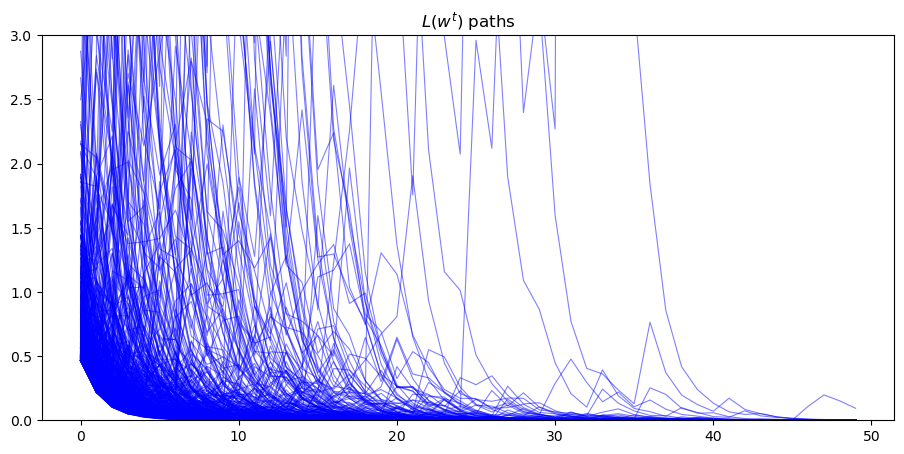

In [5]:
N, T = l_arr_g.shape

for i in range(N):

    plt.plot(range(T), l_seq_g[i, :], color='b', lw=0.8, alpha=0.5)

plt.ylim([0, 3])
plt.title("$L(w^{t})$ paths");

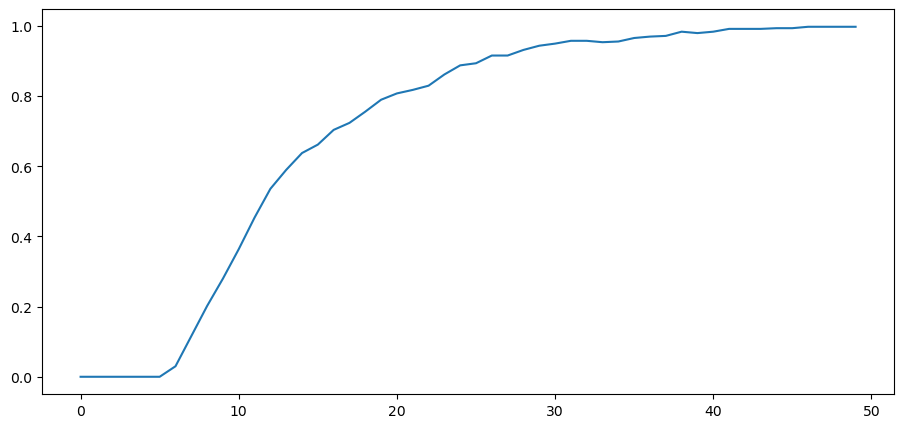

In [6]:
plt.plot(range(T), np.sum(l_seq_g <= 0.01, axis=0) / N)

In [7]:
l_arr_g = simulate(G_a, G_b, N=50000)
l_seq_g = np.cumprod(l_arr_g, axis=1)

In [8]:
l_arr_f = simulate(F_a, F_b, N=50000)
l_seq_f = np.cumprod(l_arr_f, axis=1)

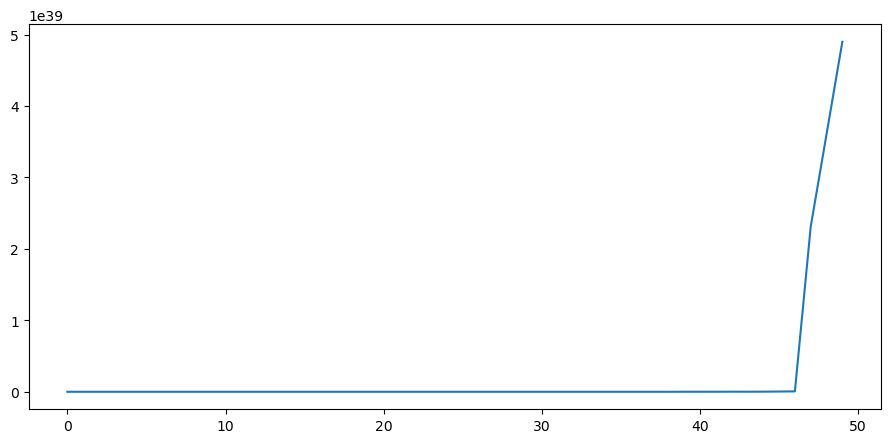

In [9]:
N, T = l_arr_f.shape
plt.plot(range(T), np.mean(l_seq_f, axis=0))

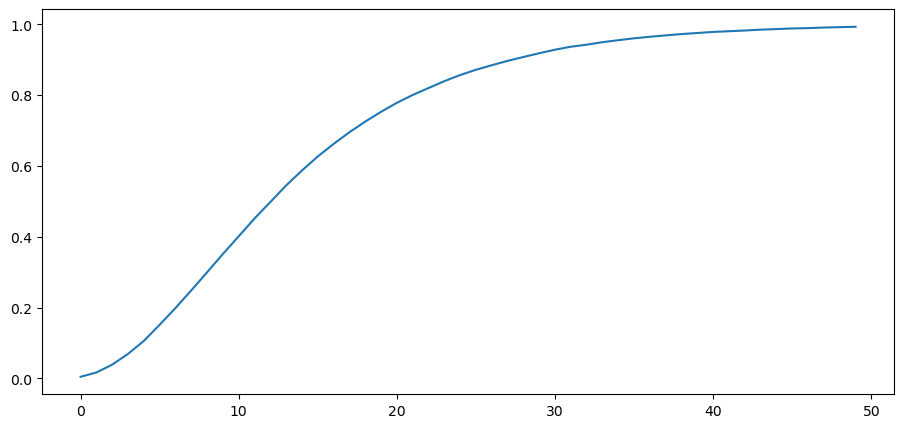

In [10]:
plt.plot(range(T), np.sum(l_seq_f > 10000, axis=0) / N)

In [11]:
c = 1

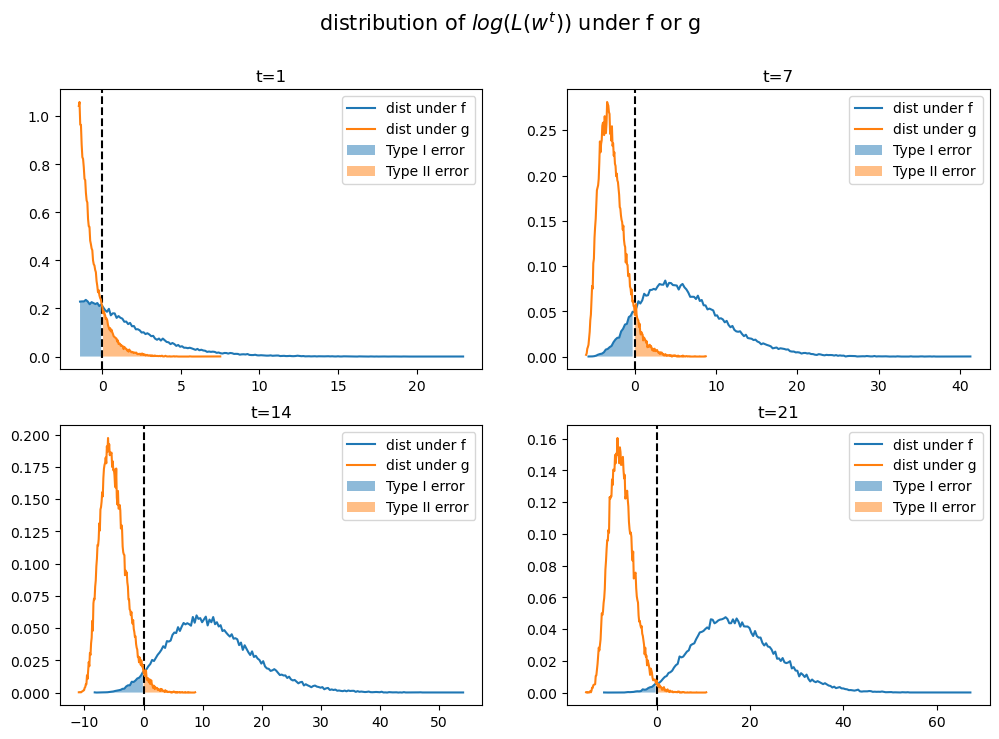

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('distribution of $log(L(w^t))$ under f or g', fontsize=15)

for i, t in enumerate([1, 7, 14, 21]):
    nr = i // 2
    nc = i % 2

    axs[nr, nc].axvline(np.log(c), color="k", ls="--")

    hist_f, x_f = np.histogram(np.log(l_seq_f[:, t]), 200, density=True)
    hist_g, x_g = np.histogram(np.log(l_seq_g[:, t]), 200, density=True)

    axs[nr, nc].plot(x_f[1:], hist_f, label="dist under f")
    axs[nr, nc].plot(x_g[1:], hist_g, label="dist under g")

    for i, (x, hist, label) in enumerate(zip([x_f, x_g], [hist_f, hist_g], ["Type I error", "Type II error"])):
        ind = x[1:] <= np.log(c) if i == 0 else x[1:] > np.log(c)
        axs[nr, nc].fill_between(x[1:][ind], hist[ind], alpha=0.5, label=label)

    axs[nr, nc].legend()
    axs[nr, nc].set_title(f"t={t}")

plt.show()

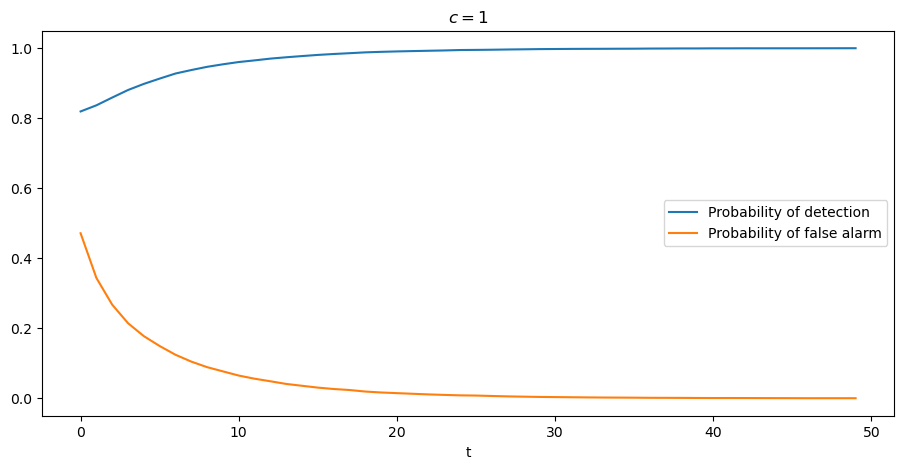

In [13]:
PD = np.empty(T)
PFA = np.empty(T)

for t in range(T):
    PD[t] = np.sum(l_seq_g[:, t] < c) / N
    PFA[t] = np.sum(l_seq_f[:, t] < c) / N

plt.plot(range(T), PD, label="Probability of detection")
plt.plot(range(T), PFA, label="Probability of false alarm")
plt.xlabel("t")
plt.title("$c=1$")
plt.legend()
plt.show()

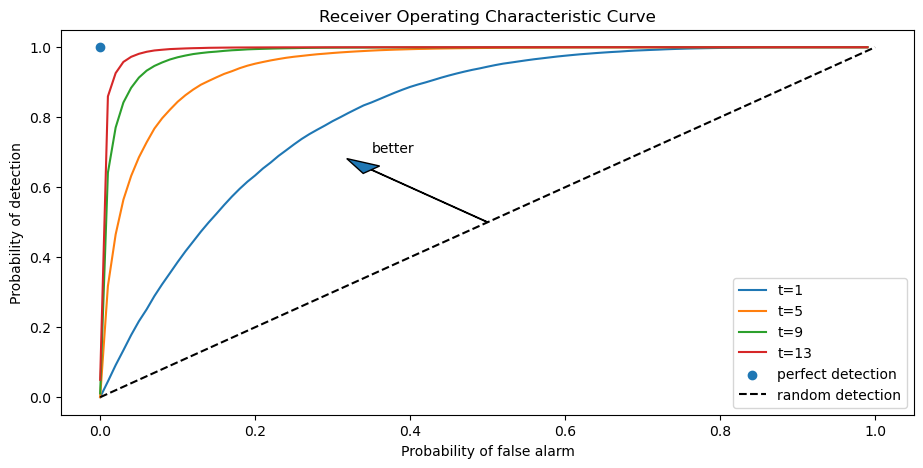

In [14]:
PFA = np.arange(0, 100, 1)

for t in range(1, 15, 4):
    percentile = np.percentile(l_seq_f[:, t], PFA)
    PD = [np.sum(l_seq_g[:, t] < p) / N for p in percentile]

    plt.plot(PFA / 100, PD, label=f"t={t}")

plt.scatter(0, 1, label="perfect detection")
plt.plot([0, 1], [0, 1], color='k', ls='--', label="random detection")

plt.arrow(0.5, 0.5, -0.15, 0.15, head_width=0.03)
plt.text(0.35, 0.7, "better")
plt.xlabel("Probability of false alarm")
plt.ylabel("Probability of detection")
plt.legend()
plt.title("Receiver Operating Characteristic Curve")
plt.show()

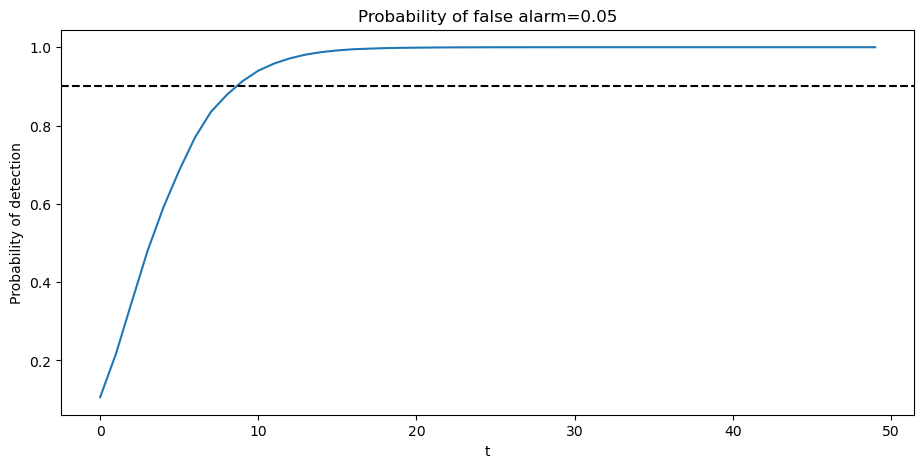

In [15]:
PFA = 0.05
PD = np.empty(T)

for t in range(T):

    c = np.percentile(l_seq_f[:, t], PFA * 100)
    PD[t] = np.sum(l_seq_g[:, t] < c) / N

plt.plot(range(T), PD)
plt.axhline(0.9, color="k", ls="--")

plt.xlabel("t")
plt.ylabel("Probability of detection")
plt.title(f"Probability of false alarm={PFA}")
plt.show()

In [16]:
H_a, H_b = 3.5, 1.8

h = njit(lambda x: p(x, H_a, H_b))

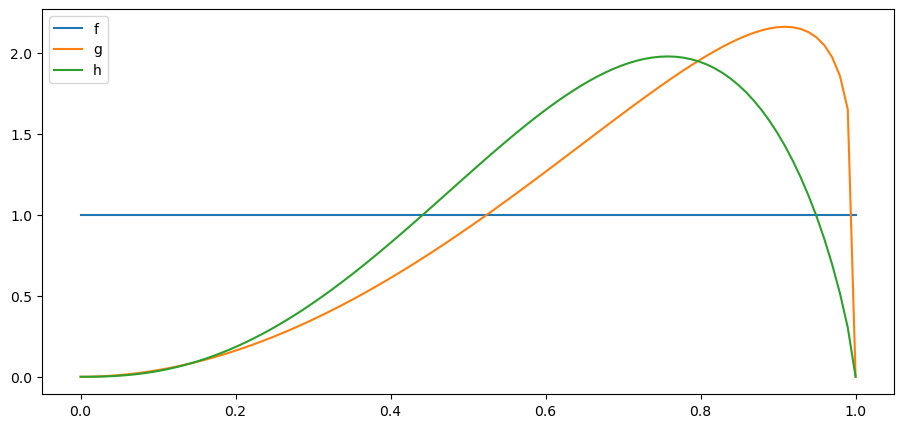

In [17]:
x_range = np.linspace(0, 1, 100)
plt.plot(x_range, f(x_range), label='f')
plt.plot(x_range, g(x_range), label='g')
plt.plot(x_range, h(x_range), label='h')

plt.legend()
plt.show()

In [18]:
def KL_integrand(w, q, h):

    m = q(w) / h(w)

    return np.log(m) * q(w)

In [19]:
def compute_KL(h, f, g):

    Kf, _ = quad(KL_integrand, 0, 1, args=(f, h))
    Kg, _ = quad(KL_integrand, 0, 1, args=(g, h))

    return Kf, Kg

In [20]:
Kf, Kg = compute_KL(h, f, g)
Kf, Kg

(0.7902536603660166, 0.08554075759988751)

In [21]:
l_arr_h = simulate(H_a, H_b)
l_seq_h = np.cumprod(l_arr_h, axis=1)

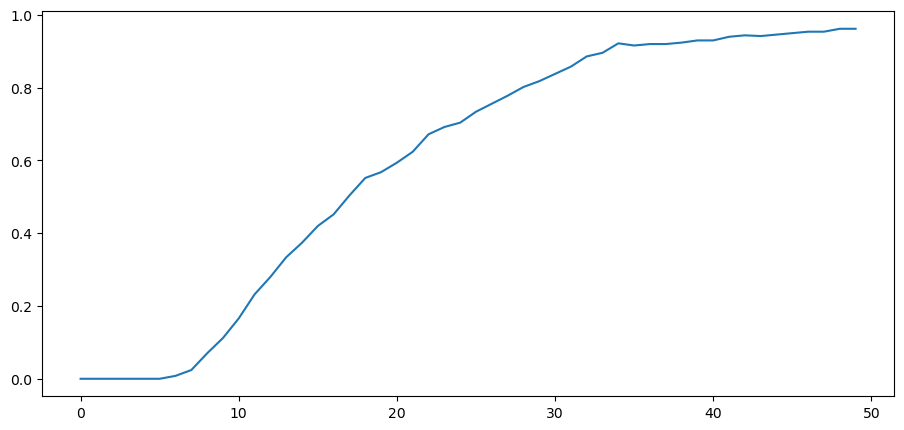

In [22]:
N, T = l_arr_h.shape
plt.plot(range(T), np.sum(l_seq_h <= 0.01, axis=0) / N)

In [23]:
H_a, H_b = 1.2, 1.2
h = njit(lambda x: p(x, H_a, H_b))

In [24]:
Kf, Kg = compute_KL(h, f, g)
Kf, Kg

(0.012392497544526706, 0.35377684280997634)

In [25]:
l_arr_h = simulate(H_a, H_b)
l_seq_h = np.cumprod(l_arr_h, axis=1)

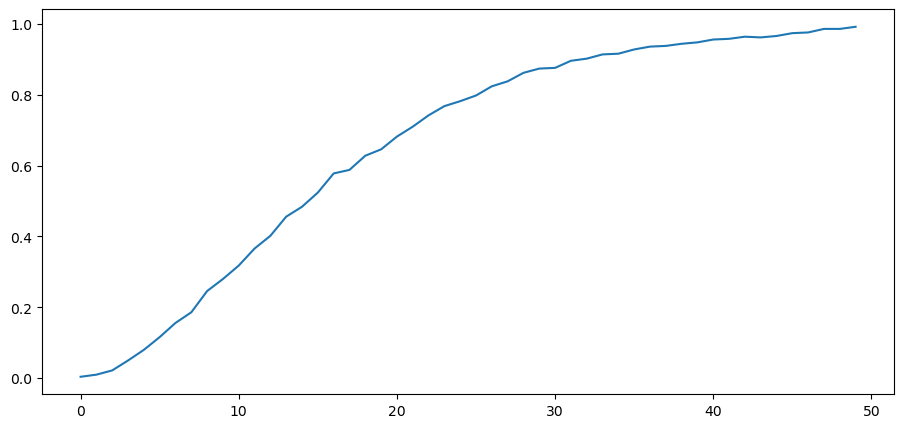

In [26]:
N, T = l_arr_h.shape
plt.plot(range(T), np.sum(l_seq_h > 10000, axis=0) / N)